In [1]:
# Exploring preparation of data set

In [1]:
# Load data
import numpy as np
import matplotlib.pyplot as plt
data = np.load("./sorted_data.npz")

In [2]:
# Find signal triggers
def findTrigIdxs(signal, threshold=0.1):
    """
    Finds the indexes of the signal where the trigger happens
    """

    mask = signal <= threshold
    mask = mask[:, np.newaxis]
    zerosIdx = np.argwhere(mask)[:, 0].astype(int)
    jumpIdx = np.argwhere(np.diff(zerosIdx)>1)[:, 0].astype(int)
    trigIdx =  zerosIdx[jumpIdx].astype(int)
    releaseIdx = zerosIdx[jumpIdx+1].astype(int)
    return trigIdx, releaseIdx

def separateIntoTriggers(signal, trigIdx, releaseIdx, width=30):
    triggers = []
    releases = []
    for i, j in zip(trigIdx, releaseIdx):
        triggers.append(signal[i:i+width])
        releases.append(signal[j-width:j])
    return np.array(triggers), np.array(releases) 


def plotTriggers(triggers, name):
    plt.figure(figsize=(15,15))
    plt.suptitle(name)
    N = len(triggers)
    for i in range(N):
        if i+1 > int(np.sqrt(N))**2: continue    # Skip some signals to avoid error due to outside of grid
        plt.subplot(int(np.sqrt(N)), int(np.sqrt(N)), i+1)
        trig = triggers[i]
        plt.plot(range(len(trig)), trig, "b.")

def plotSignal(signal):
    plt.figure()
    plt.plot(range(len(signal)), signal, "b.")
    plt.show()

(8000,)


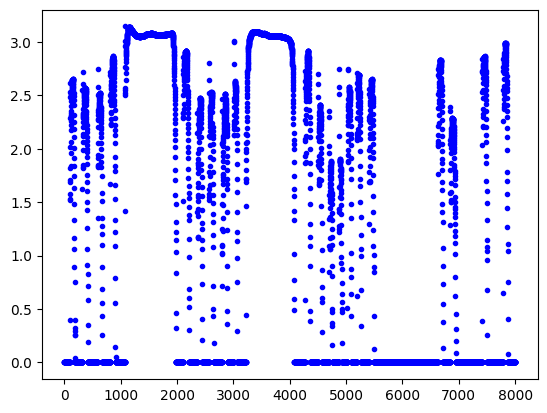

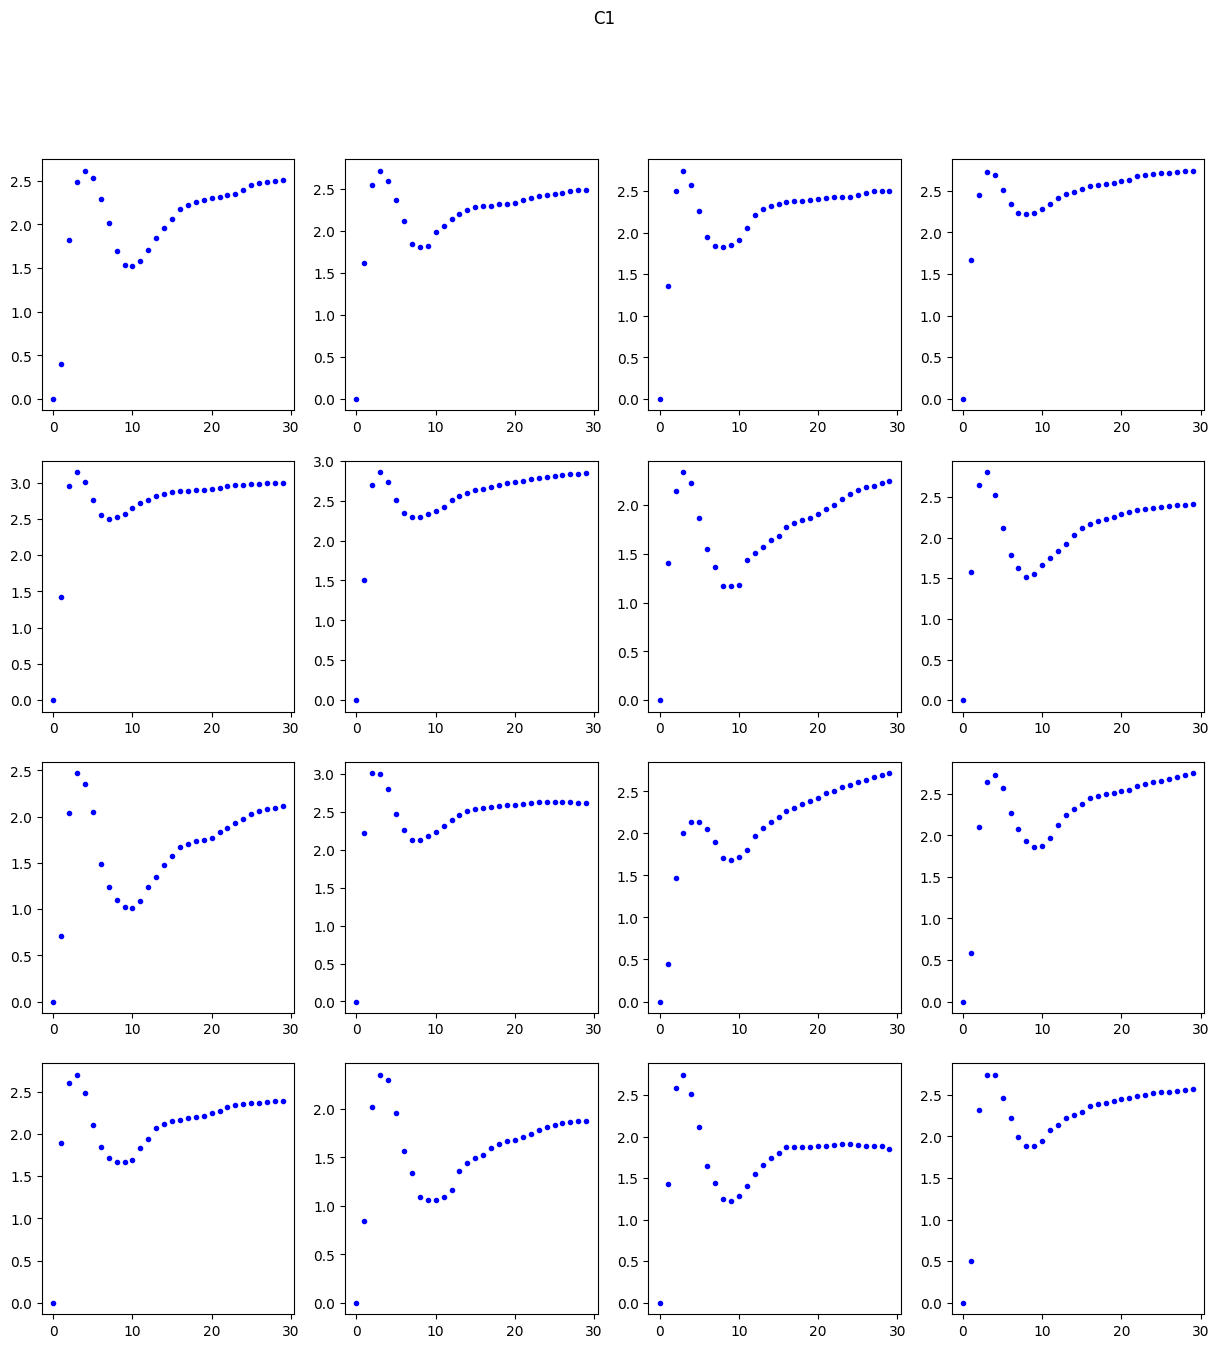

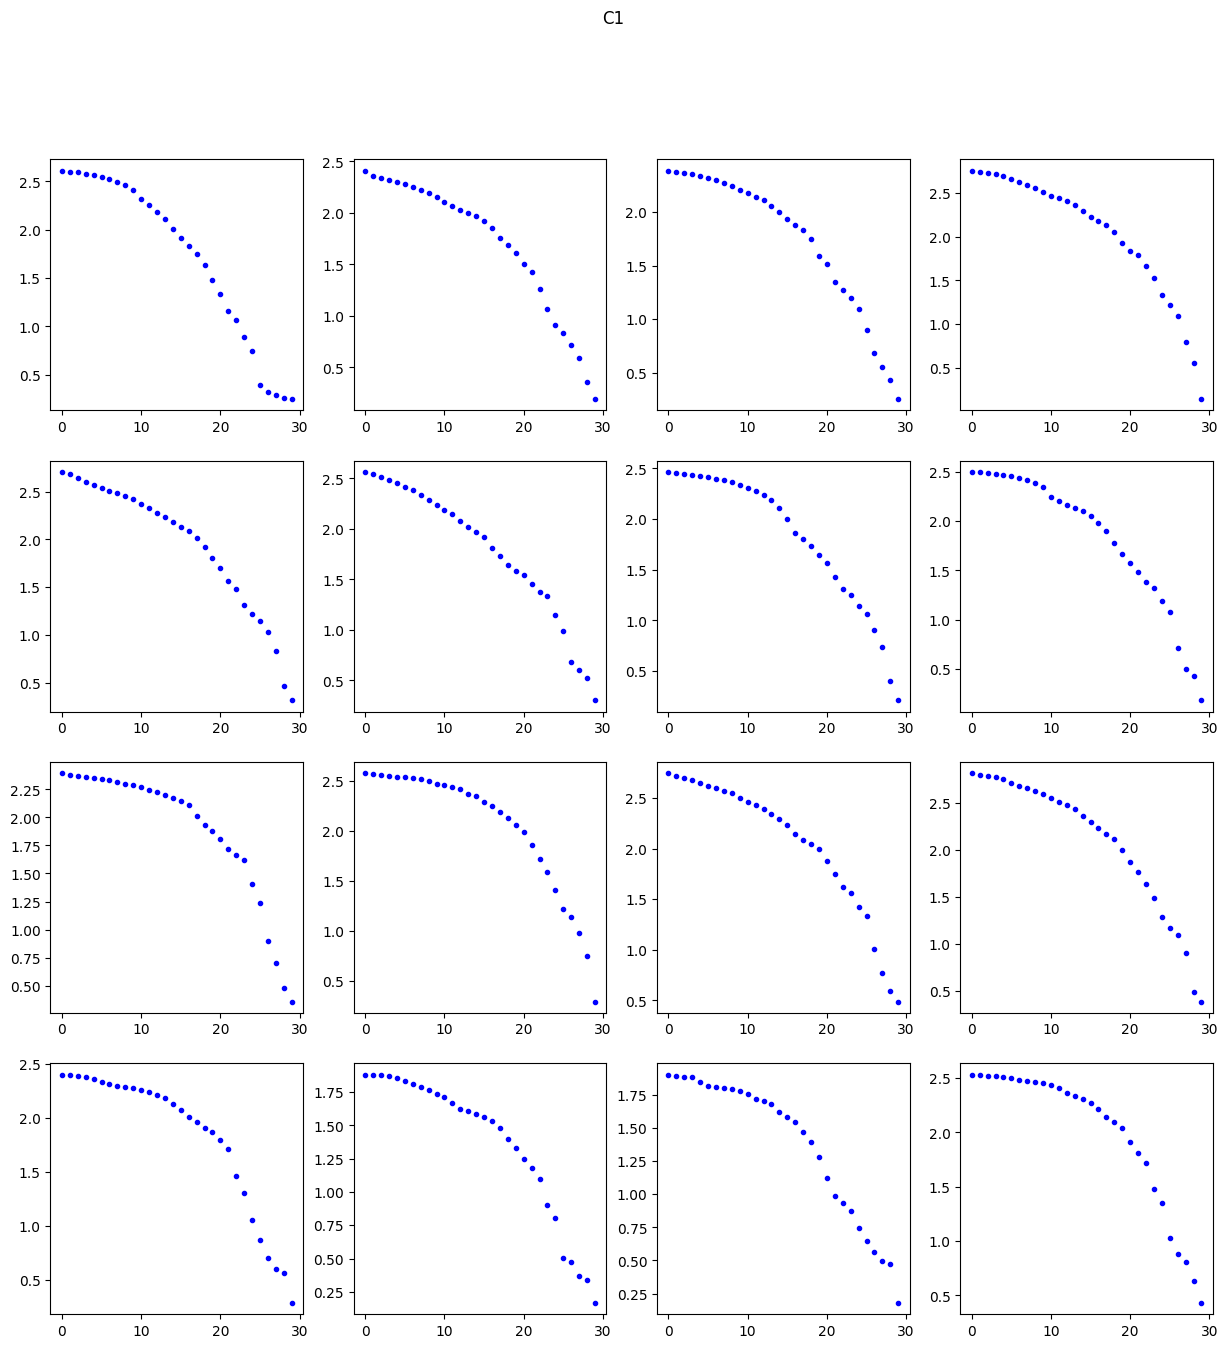

In [4]:
# Look at triggers

key = "C1"
signal = data[key][0]
print(signal.shape)
trigIdx, relIdx = findTrigIdxs(signal)
triggers, releases = separateIntoTriggers(signal, trigIdx, relIdx)
plotSignal(signal)
plotTriggers(triggers, key) 
plotTriggers(releases, key)

(8000,)


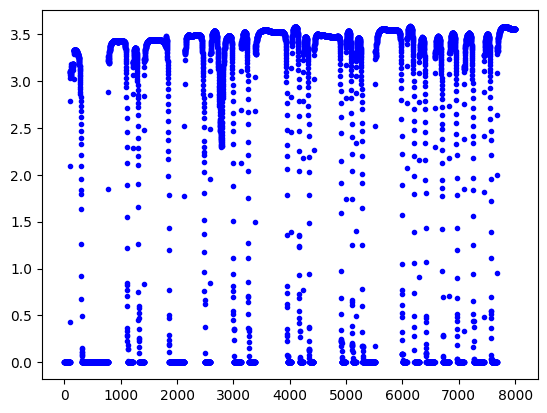

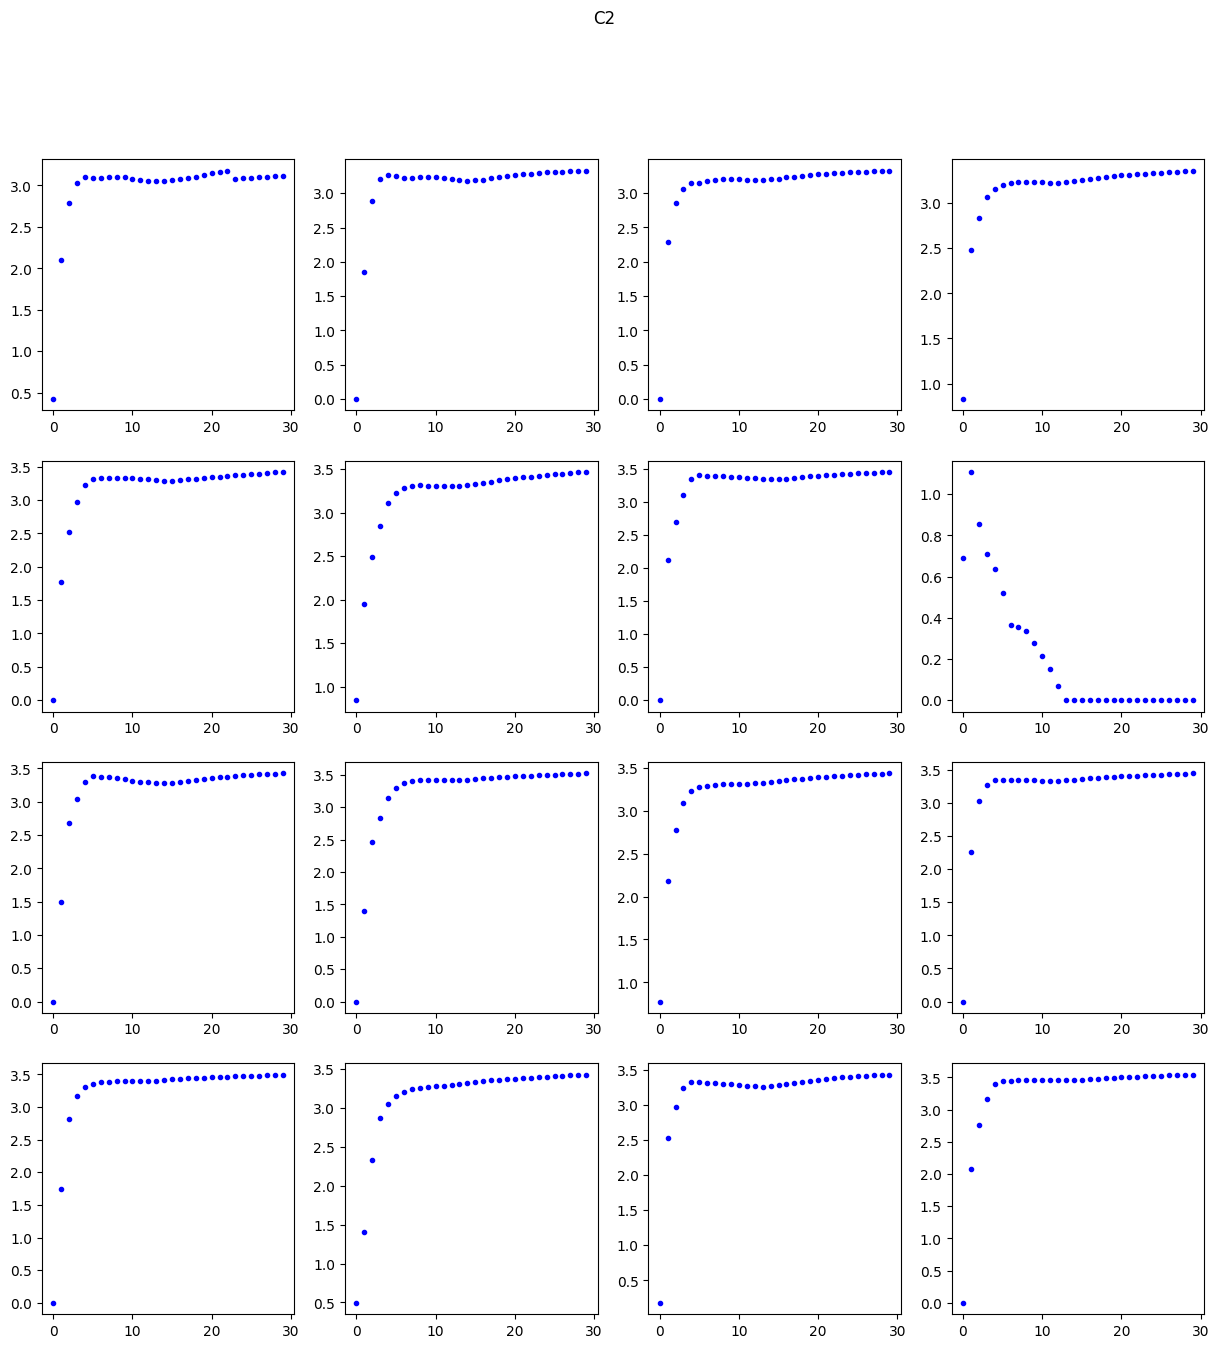

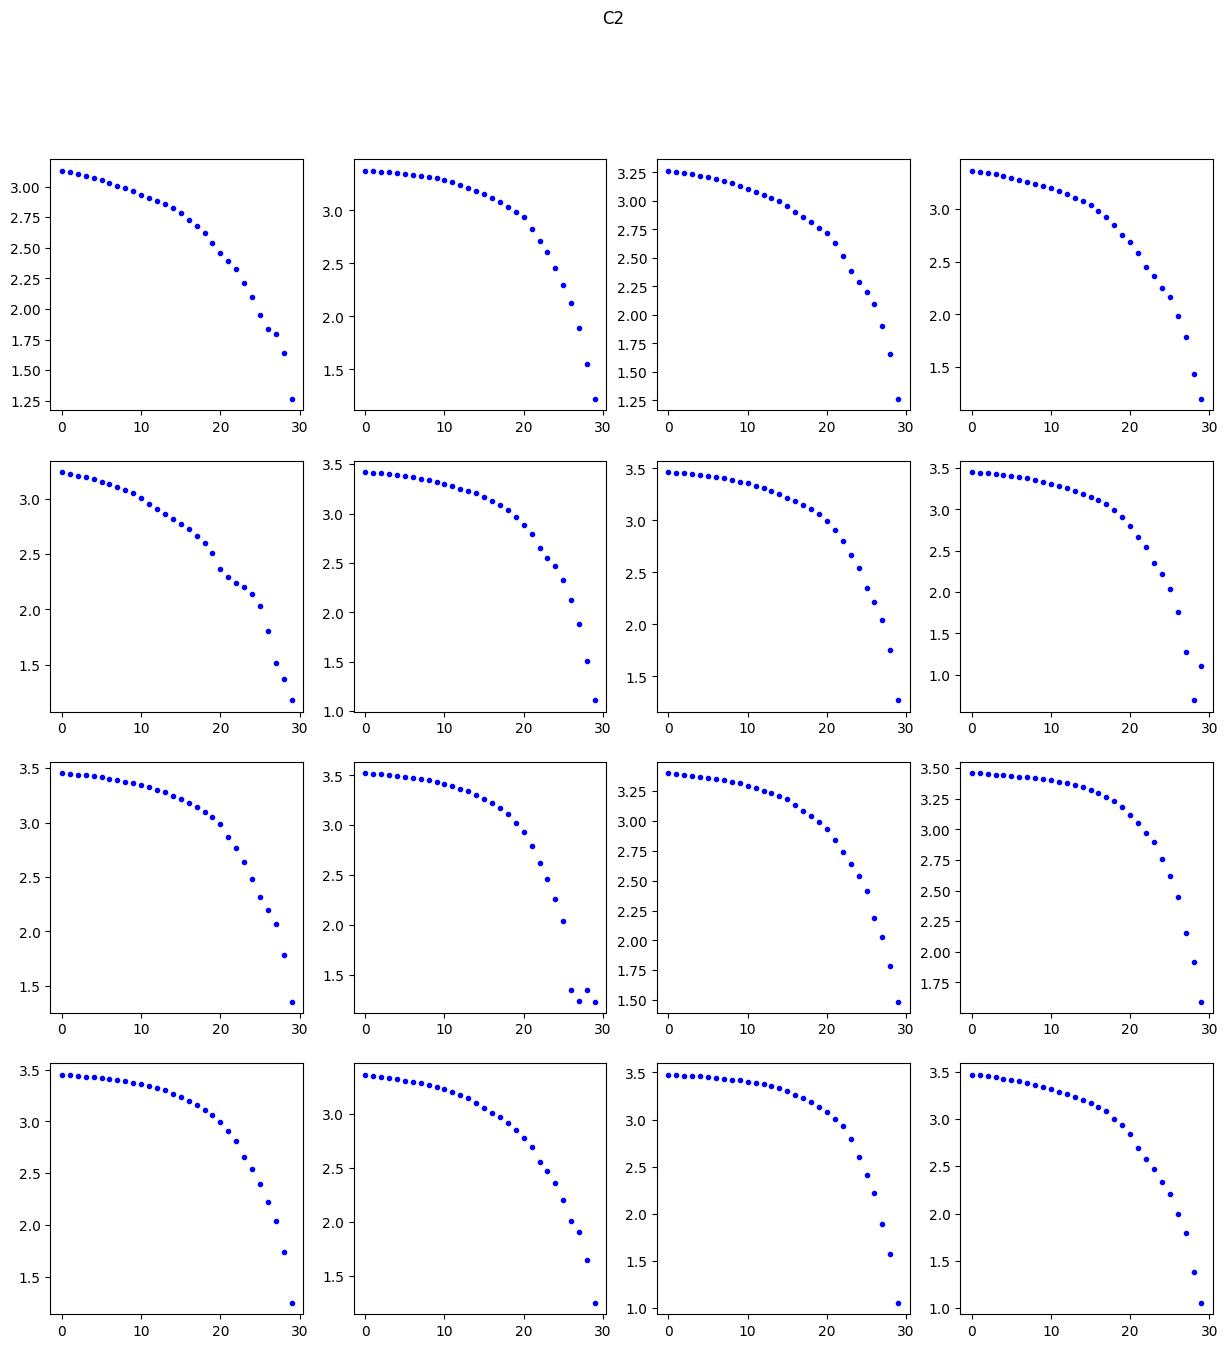

In [6]:
key = "C2"
signal = data[key][0]
print(signal.shape)
trigIdx, relIdx = findTrigIdxs(signal, threshold=1)
triggers, releases = separateIntoTriggers(signal, trigIdx, relIdx)
plotSignal(signal)
plotTriggers(triggers, key) 
plotTriggers(releases, key)

In [8]:
# Filter data into triggers and save it
filteredData = {}
for key in data:
    signal = data[key].flatten()
    trigIdx, relIdx = findTrigIdxs(signal, threshold=1)
    triggers, releases = separateIntoTriggers(signal, trigIdx, relIdx)
    filteredData[key+"triggers"] = triggers
    filteredData[key+"releases"] = releases 
    print("saving ", triggers.shape)
    print("saving ", releases.shape)

savePath = "./triggers_data.npz"
np.savez(savePath, **filteredData)

saving  (91, 30)
saving  (91, 30)
saving  (86, 30)
saving  (86, 30)
